<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2022/blob/master/06-model-evaluation/QualityMetrics_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cross-validation riddle

Here's a small example of cross-validation done wrongly. Can you spot the problem?

In [11]:
# Some imports...
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score

**Plan:**

- Let's create a binary classification dataset where targets are completely independent from the features
  - *(i.e. no model could ever predict them well)*
- We'll do some simple feature selection
- And cross-validate a model on this data

**Q:** what accuracy do we expect (classes are even)?

We'll start from writing a class to select the best features:

In [2]:
class FeatureSelector:
  def __init__(self, num_features):
    self.n = num_features # number of best features to select

  def fit(self, X, y):
    # Select features that describe the targets best, i.e. have
    # highest correlation with them:
    covariance = ((X - X.mean(axis=0)) * (y[:,np.newaxis] - y.mean())).mean(axis=0)
    self.best_feature_ids = np.argsort(np.abs(covariance))[-self.n:]

  def transform(self, X):
    return X[:,self.best_feature_ids]

  def fit_transform(self, X, y):
    self.fit(X, y)
    return self.transform(X)

In [6]:
num_features_total = 1000
num_features_best = 100

N = 100

# Dataset generation
X = np.random.normal(size=(N, num_features_total))
y = np.random.randint(2, size=N)

# Feature selection:
X_best = FeatureSelector(num_features_best).fit_transform(X, y)

# Simple classification model
model = LinearSVC()

# Estimatin accuracy using cross-validation:
cv_score = cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()
print(f"CV score is {cv_score}")

CV score is 0.9700000000000001


What's going on?! Why accuracy is so high?

Maybe it just happened by chance? Let's repeat this experiment many times and histogram the results:

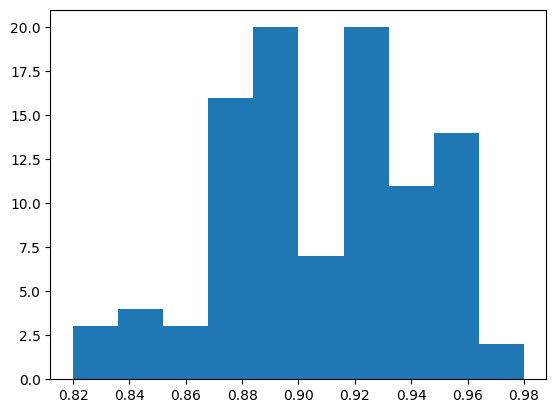

In [4]:
num_features_total = 1000
num_features_best = 100

N = 100
def experiment():
  # Dataset generation
  X = np.random.normal(size=(N, num_features_total))
  y = np.random.randint(2, size=N)

  # Feature selection:
  X_best = FeatureSelector(num_features_best).fit_transform(X, y)

  # Simple classification model
  model = LinearSVC()

  # Estimatin accuracy using cross-validation:
  return cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

results = [experiment() for _ in range(100)]
plt.hist(results, bins=10)

## Task 1 (3 points)

Explain why the estimated model accuracy is not 50% on a dataset where targets were generated **independently from the features (!!!)**.

Find and fix the problem (don't change the dataset generation or its parameters - `num_features_total`, `num_features_best`, `N`).

*Hint: the problem is in the overall logic, and not a bug in the code.*

Проблема: один раз для полного датасета находятся лучшие параметры, а надо на каждом фолде на трейне искать лучшие параметры.

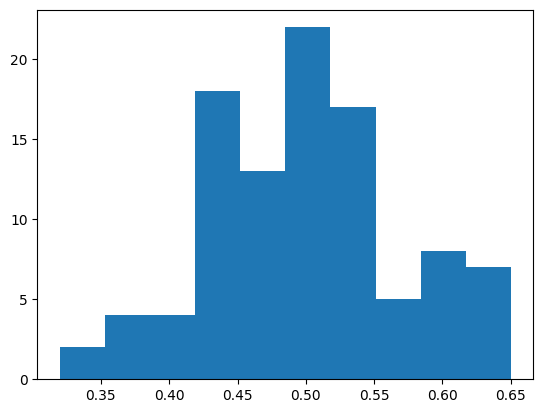

In [12]:
num_features_total = 1000
num_features_best = 100

N = 100
def experiment():
  # Dataset generation
  X = np.random.normal(size=(N, num_features_total))
  y = np.random.randint(2, size=N)

  model = make_pipeline(
    FeatureSelector(num_features_best),
    LinearSVC()
  )

  # Estimatin accuracy using cross-validation:
  return cross_val_score(model, X, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

results = [experiment() for _ in range(100)]
plt.hist(results, bins=10);

## Task 2 (3 points)

Let's come back to Task 3 of Data Handling HW.
Build a model with KNeighborsClassifier to get a higher accuracy on 5-fold Cross Validation than you achieve using your previosly fitted model (you can just copy the params from the previous notebook). 

Use `sklearn.model_selection.GridSearchCV` to find best parameters.  You may check the parameters'  description as follows:
``` python
help(KNeighborsClassifier)
```

In [15]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

data = pd.read_csv("train.csv", index_col='PassengerId')

In [17]:
class FeaturePreprocessor:
  def fit(self, X, y):
    # Select features that describe the targets best, i.e. have
    # highest correlation with them:
    self.mean_fare = X['Fare'].mean()


  def transform(self, X):
    features = X[["Fare", "Parch", "SibSp"]].copy()
    features['Fare'] /= self.mean_fare
    features['Fare'] *= 1
    return features

  def fit_transform(self, X, y):
    self.fit(X, y)
    return self.transform(X)

In [56]:
def feature_selection_and_preprocessing(dataset):
  # <YOUR CODE>
  # E.g.:
  features = dataset[["Fare", "Parch", "SibSp"]].copy()
  features["Fare"] /= features["Fare"].mean()

  features['Fare'] *= 1
  return features

In [60]:
def group_cabin(cabin):
    if cabin in ['A','B','C','T']:
        return 0
    elif cabin in ['D','E']:
        return 1
    elif cabin in ['F','G']:
        return 2
    else:
        return 3

In [73]:
def feature_selection_and_preprocessing(dataset: pd.DataFrame) -> pd.DataFrame:
    features = dataset[["Fare", 'Pclass', 'Age']].copy()
    features["Age"] = dataset.Age.fillna(28.)  # Почти единственное, что тут было, и, вроде как, не очень правильное, поэтому чуть-чуть хардкода, чтобы не выдавало ошибок
    features["Log_Fare"] = np.log(features["Fare"] + 1)
    features['Embarked'] = dataset.Embarked.fillna('S')
    features['Missing'] = dataset.isna().sum(axis=1)
    features['IsMale'] = np.where(dataset.Sex=='male', 1, 0)
    features['Companions'] = dataset.SibSp + dataset.Parch
    features['IsAlone'] = np.where((dataset.SibSp == 0) & (dataset.Parch == 0), 1, 0)
    features['Embarked_S'] = np.where(features.Embarked == 'S', 1, 0) # ДА, это ручной onehot
    features['Embarked_C'] = np.where(features.Embarked == 'C', 1 ,0)
    features.drop('Embarked', axis=1, inplace=True)
    features['Prefix'] = data.Name.apply(lambda x: x.split(',')[1].split('.')[0]).apply(
        lambda y: 'other' if y in (data.Name.apply(lambda x: x.split(',')[1].split('.')[0]).value_counts())
        [(data.Name.apply(lambda x: x.split(',')[1].split('.')[0]).value_counts() <= 5)]
        else y)  # Вычленяем префиксы имен и заменяем те, что встречаются 1 раз на other (да, я знаю, что это можно сделать в разы более читаемо)
    features['Cabin_Group'] = dataset.Cabin.fillna('Z').apply(lambda x: x[0]).apply(lambda y: group_cabin(y)) # Вычленяем первую букву и превращаем в цифру в зависимости от группы

    return features

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

In [84]:
np.random.seed(42)

model = make_pipeline(
    make_column_transformer(
        (SimpleImputer(strategy='median', copy=False), ['Age']), # Как я понимаю, с пропусками надо работать этой штукой, а не грубой вставкой из данных по всему датасету
        (OneHotEncoder(sparse_output=False), ['Prefix']),
        # (PolynomialFeatures(3), ['Companions', 'Missing', 'Pclass', 'Fare', 'Log_Fare', 'Age']),
        remainder='passthrough'
    ),
    StandardScaler(),
    KNeighborsClassifier()
)

data = pd.read_csv("train.csv", index_col='PassengerId')

# cross_val_score(model, data, data['Survived'], scoring='accuracy', cv=5, n_jobs=-1).mean()
# param_grid = {'kneighborsclassifier__n_neighbors': np.arange(1, 40), 'kneighborsclassifier__weights':['uniform', 'distance'], 'kneighborsclassifier__p': np.linspace(1, 3 ,10)}
param_grid = {'kneighborsclassifier__n_neighbors': np.arange(5, 40), 'kneighborsclassifier__p': np.linspace(1, 4 ,10), 'kneighborsclassifier__weights':['uniform', 'distance']}
gcv = GridSearchCV(model, param_grid, scoring='accuracy', cv=5, n_jobs=-1)
gcv.fit(feature_selection_and_preprocessing(data), data['Survived'])
# model.fit(feature_selection_and_preprocessing(data), data['Survived'])
print(gcv.best_score_)
print(gcv.best_params_)

0.8260372857949909
{'kneighborsclassifier__n_neighbors': 16, 'kneighborsclassifier__p': 2.0, 'kneighborsclassifier__weights': 'uniform'}


Просто перебирать параметры классификатора по сетке с той предобработкой, что была в первом дз, оказалось недостаточным, чтобы добиться accuracy больше 0.77, поэтому просто скопировал модель из 3 дз. Заданию вроде как не противоречит. Модель с kNN построил? Построил. Кросс-валидацию на 5 фолдов использовал? Использовал. Лучше метрика, чем в 1 дз? Лучше.